In [78]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib auto
plt.style.use('ggplot')#makes nicer plots without work

train_df = pd.read_csv('/home/kevin/Documents/data/housing/train.csv')
test_df = pd.read_csv('/home/kevin/Documents/data/housing/test.csv')

test_index = test_df['Id']#We'll remove this later

In [53]:
#print(plt.style.available)

In [54]:
print(train_df.head(2))
print(test_df.head(2))

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  

[2 rows x 81 columns]
     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   

  LandContour Utilities      ...       ScreenPorch PoolArea PoolQC  Fence  \
0         Lvl    AllPub      ...             

In [55]:
train_df = train_df.drop('Id', 1)
test_df = test_df.drop('Id',1)
col_labels = list(train_df.columns)#convert to list to turn objects to strs

print(col_labels)

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fen

In [56]:
print("train_df.shape = {}, test_df.shape = {}".format(train_df.shape, test_df.shape))

train_df.shape = (1460, 80), test_df.shape = (1459, 79)


In [57]:
#remove columns wih few non-null values
train_df = train_df.drop(['Alley', 'FireplaceQu','PoolQC', 'Fence', 'MiscFeature'], 1)
test_df = test_df.drop(['Alley', 'FireplaceQu','PoolQC', 'Fence', 'MiscFeature'], 1)

In [58]:
print("train_df.shape = {}, test_df.shape = {}".format(train_df.shape, test_df.shape))
#We removed 5 columns

train_df.shape = (1460, 75), test_df.shape = (1459, 74)


In [59]:
#data imputation
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series(
            [X[c].value_counts().index[0]
            if X[c].dtype==np.dtype('O') else X[c].median() for c in X], index=X.columns)
        return self
    def transform(self,X, y=None):
        return X.fillna(self.fill)

In [60]:
#join features
feature_labels = test_df.columns
my_features = list(range(len(feature_labels)))
X_train = train_df[my_features]
X_test = test_df[my_features]

#print(X_train.head(2))
#print(X_test.head(2))

big_X = X_train.append(X_test)

big_X_imputed = DataFrameImputer().fit_transform(big_X)
print("X_train.shape = {}, X_test.shape = {}, big_X.shape = {}".format(
        X_train.shape, X_test.shape, big_X.shape))
big_X_imputed.head(2)

X_train.shape = (1460, 74), X_test.shape = (1459, 74), big_X.shape = (2919, 74)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal


In [61]:
#find non_numeric features since XGBoost doens't work with categorical features
non_numeric_features= []
for feature, dtype in enumerate(big_X_imputed.dtypes):
    #print(big_X_imputed.columns[feature], dtype)
    if dtype == object:
        non_numeric_features.append(big_X_imputed.columns[feature])
print("len(non_numeric_features): ", len(non_numeric_features))
print(non_numeric_features)


len(non_numeric_features):  38
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [62]:
#convert categorical features to integers
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for feature in non_numeric_features:
    big_X_imputed[feature] = le.fit_transform(big_X_imputed[feature])

In [63]:
#big_X_imputed.info()
big_X_imputed.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,3,3,0,4,0,...,61,0,0,0,0,0,2,2008,8,4
1,20,3,80.0,9600,1,3,3,0,2,0,...,0,0,0,0,0,0,5,2007,8,4


In [65]:
#prepare inputs for model
train_X = big_X_imputed[0:X_train.shape[0]].as_matrix()
test_X = big_X_imputed[X_train.shape[0]::].as_matrix()
train_y = train_df['SalePrice']

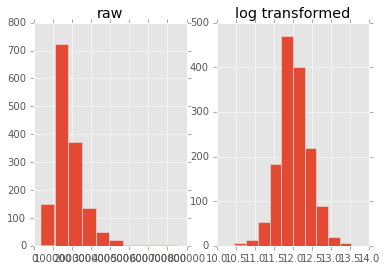

In [66]:
#need to log transform so that cheap houses and expensive houses are equally weighted. 
#We don't want expensive houses to dominate.
plt.subplot(1,2,1)
plt.title('raw')
train_y.hist()

plt.subplot(1,2,2)
plt.title('log transformed')
train_y.apply(np.log).hist()

In [67]:
train_y = train_y.apply(np.log)

In [68]:
print("train_X.shape = {},\ntest_X.shape = {},\ntrain_y.shape() = {}".format(
    train_X.shape, test_X.shape, train_y.shape))

train_X.shape = (1460, 74),
test_X.shape = (1459, 74),
train_y.shape() = (1460,)


In [69]:
#XGBOOST
import pickle
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
err = []

In [70]:
kf = KFold(5)

In [71]:
#errors look obscenely large...before the log transform.
for train_index, test_index in kf.split(train_X):
    #print("Train: ", train_index, ", Test: ", test_index)
    #fit fold
    xgb_model = xgb.XGBRegressor().fit(train_X[train_index], train_y[train_index])
    predictions = xgb_model.predict(train_X[test_index])
    actuals = train_y[test_index]
    err.append(mean_squared_error(actuals, predictions))
print("Errors: ",err)

Errors:  [0.013931335134448695, 0.021071190074793505, 0.018134963394421926, 0.014287029463296618, 0.019013999532209711]


In [72]:
#parameter optimization
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model, {'max_depth': [2,3],
                   'n_estimators': [800,1000],
                              'learning_rate': [.075,.1],
                              'reg_lambda':[.75,1],
                              'reg_alpha':[0,1e-5],
                              }, 
                   scoring = 'neg_mean_squared_error',
                   verbose = 1)
clf.fit(train_X, train_y)
clf.best_score_, clf.best_params_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   35.9s finished


(-0.015684356867696172,
 {'learning_rate': 0.1,
  'max_depth': 2,
  'n_estimators': 1000,
  'reg_alpha': 1e-05,
  'reg_lambda': 1})

In [73]:
#clf.get_params

In [74]:
#convert back to actual price
logpredictions = clf.predict(test_X)
print(logpredictions)
predictions = np.array([np.exp(x) for x in logpredictions])
print(predictions)

[ 11.72449303  11.96258926  12.14687061 ...,  12.03166389  11.61701775
  12.32793045]
[ 123561.34375    156778.5        188503.265625  ...,  167990.703125
  110970.2890625  225918.6875   ]


In [79]:
#export to csv
test_index.shape

(1459,)

In [80]:
pred_df = pd.DataFrame(predictions, index = test_index, columns = ['SalePrice'] )

In [81]:
pred_df.head(2)

,SalePrice
Id,
1461,123561.34375
1462,156778.50000


In [82]:
pred_df.to_csv('output.csv', header = True, index_label = 'Id')

In [115]:
#xgb.plot_importance(clf)
#plt.show()

In [87]:
gbm = xgb.XGBRegressor(max_depth = 2, n_estimators= 1000, learning_rate=.1, reg_alpha=1e-05, reg_lambda = 1).fit(train_X, train_y)

In [88]:
predictions = gbm.predict(test_X)

In [90]:
print(predictions)

[ 11.72449303  11.96258926  12.14687061 ...,  12.03166389  11.61701775
  12.32793045]


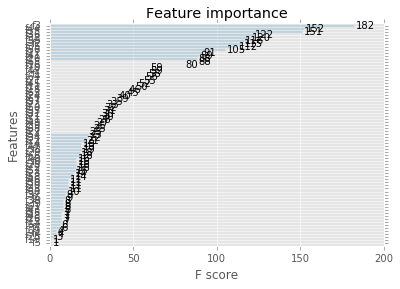

In [91]:
xgb.plot_importance(gbm)
plt.show()

In [92]:
X_train.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal


In [93]:
X_train.columns[[44,32,3,15,35]]

Index(['GrLivArea', 'BsmtFinSF1', 'LotArea', 'OverallQual', 'BsmtUnfSF'], dtype='object')

In [94]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, train_X, train_y, scoring='neg_mean_squared_error')

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   30.8s finished


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   31.9s finished


Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   30.8s finished


array([-0.01262227, -0.02108672, -0.01498771])

In [95]:
X_train.columns[[0,4,36,45, 37, 42, 60]]

Index(['MSSubClass', 'Street', 'TotalBsmtSF', 'BsmtFullBath', 'Heating',
       '2ndFlrSF', 'GarageQual'],
      dtype='object')

In [96]:
X_train.columns[[21,61]]

Index(['Exterior1st', 'GarageCond'], dtype='object')

In [97]:
#xgb.plot_tree(gbm)

In [98]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions) )
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [99]:
#modelfit(gbm, train_X, X_train.columns)